In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
import torch 
import torch.nn as nn 
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision 
from typing import Tuple, Any
from torchvision import datasets, models
import torchvision.transforms as T
import random
import cv2
from PIL import Image
import os

# **Section 1: The Data**

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
!unzip /content/drive/MyDrive/CS231N/Projects_The_good_stuff/P4GANs/birds_dataset.zip

In [ ]:
 base_path = "/content"
 train_path = base_path + "/train"

In [ ]:
category_map = {}
train_count = 0
train_images = []

for idx, entry in enumerate(os.listdir(train_path)):
  
  if os.path.isdir(os.path.join(train_path, entry)):
    category_map[entry] = idx
    train_count+= len(os.listdir(train_path+"/"+entry))
  
    for img in os.listdir(train_path+"/"+entry):
    
      train_images.append(train_path+"/"+entry+"/"+img)

print(train_count) #verify number of training images
print(train_images[0]) #Verify what the paths look like 

70626
/content/train/AUCKLAND SHAQ/091.jpg


In [ ]:
class birds_dataset(Dataset):
  
  def __init__(self, images, birds_classes, transform):
    
    super().__init__()
    self.images = images 
    self.class_map = birds_classes 
    self.transforms = transform
  
  def __getitem__(self, index):
    
    img_path = self.images[index]
    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    
    image = Image.fromarray(image.astype(np.uint8))
    
    label = img_path.split("/")[-2]
    label = self.class_map[label]   

    if self.transforms:
      image = self.transforms(image)
    
    return image, label 

In [28]:
train_transform = T.Compose([T.Resize((128, 128))])
train_set = birds_dataset(train_images, category_map, train_transform)

0


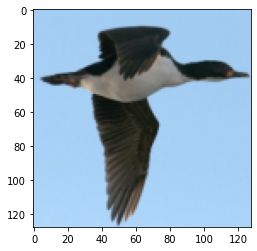

In [29]:
plt.imshow(train_set[1][0]) #128x128 seems like a good resolution feasibility and quality wise 
print(train_set[1][1]) #label verification 

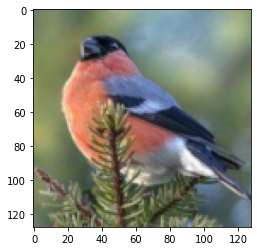

In [32]:
#here's another fun random bird 
random_int = random.randint(0, 60000)
plt.imshow(train_set[random_int][0])

In [ ]:
train_transform = T.Compose([T.Resize((128, 128)), T.ToTensor()])
train_set = birds_dataset(train_images, category_map, train_transform)

# **Section 2: The Model**

In [14]:
generator_features = 128 
discriminator_features = 128 
prior_size = 100 
num_channels = 3

In [ ]:
#The following function was taken from :
#https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
#It applies the random weight initializations as specified by Goodfellow et. al. 
#2016 

def weights_initialization(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [24]:
class Generator(nn.Module):

  def __init__(self):
    #define computational graph 
    super(Generator, self).__init__()
    self.block1 = nn.Sequential(
        nn.ConvTranspose2d(prior_size, generator_features * 8, 4, bias = False),
        nn.BatchNorm2d(generator_features*8),
        nn.ReLU(True)
    )
    self.block2 = nn.Sequential(
        nn.ConvTranspose2d(generator_features*8, generator_features*4, 4, 2, 1, bias = False),
        nn.BatchNorm2d(generator_features*4),
        nn.ReLU(True)
    )
    self.block3 = nn.Sequential(
        nn.ConvTranspose2d(generator_features*4, generator_features*2, 4, 2, 1, bias = False),
        nn.BatchNorm2d(generator_features*2),
        nn.ReLU(True)
    )
    self.block4 = nn.Sequential(
        nn.ConvTranspose2d(generator_features*2, generator_features, 4, 2, 1, bias = False),
        nn.BatchNorm2d(generator_features*2),
        nn.ReLU(True)
    )
    self.block5 = nn.Sequential(
        nn.ConvTranspose2d(generator_features, num_channels, 4, 2, 1, bias = False),
        nn.Tanh()
    )
  
  def forward(self, x):
    #define forward pass
    out = self.block1(x)
    out = self.block2(out)
    out = self.block3(out)
    out = self.block4(out)
    out = self.block5(out)

    return out

In [34]:
generator_model = Generator()
generator_network = generator_model.to(device)

In [ ]:
class Discriminator(nn.Module):
  
  def __init__(self):
    #Define computational graph 
    self.block1 = nn.Sequential(
        nn.Conv2d(num_channels, discriminator_features, 4, 2, 1, bias = False)
        nn.LeakyReLU()
    )
  def forward(self, x):
    #define forward pass 